In [1]:
from scipy import io
import numpy as np

import matplotlib.pyplot as plt

plt.style.use("seaborn")

from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge, LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

/tmp/ipykernel_250545/1655705245.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
data = io.loadmat("burgers_data_R10.mat")

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

## Importing the data and creating the B-splines

In [4]:
def get_data(ntrain, ntest):
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = io.loadmat("burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]
    
        
    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]
    
    return x_branch_train, y_train, x_branch_test, y_test, grid


    x_train = (x_branch_train, grid)
    x_test = (x_branch_test, grid)
    return x_train, y_train, x_test, y_test

In [5]:
x, y, x_test, y_test, grid = get_data(2048-200, 200)

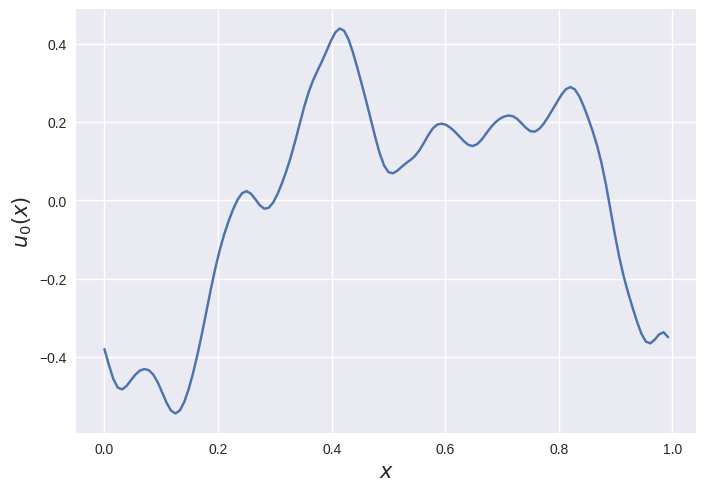

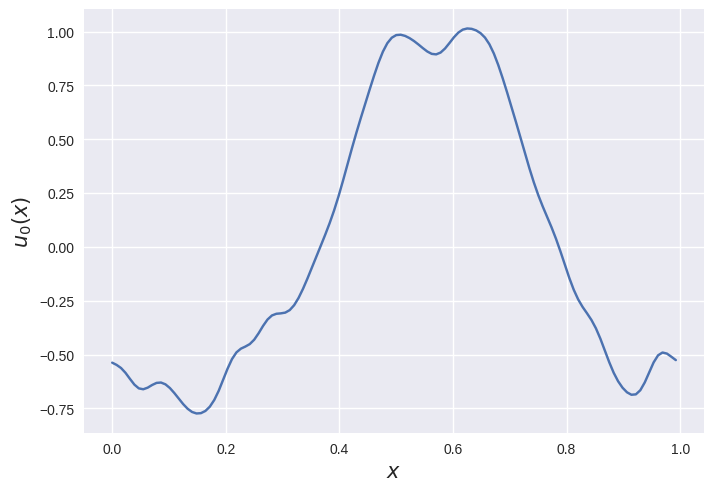

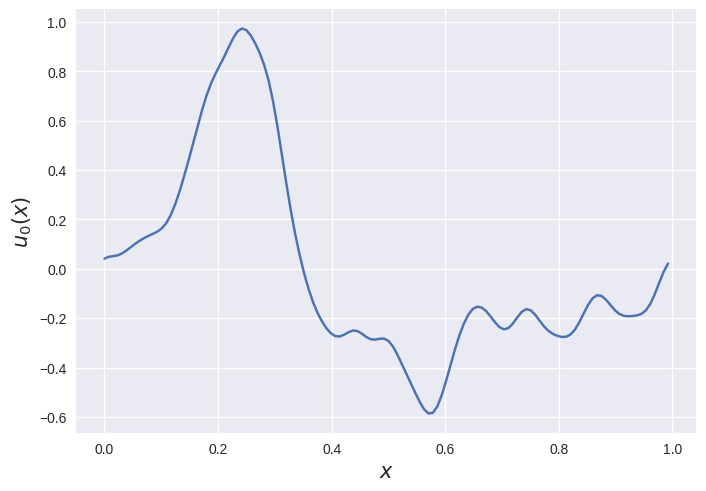

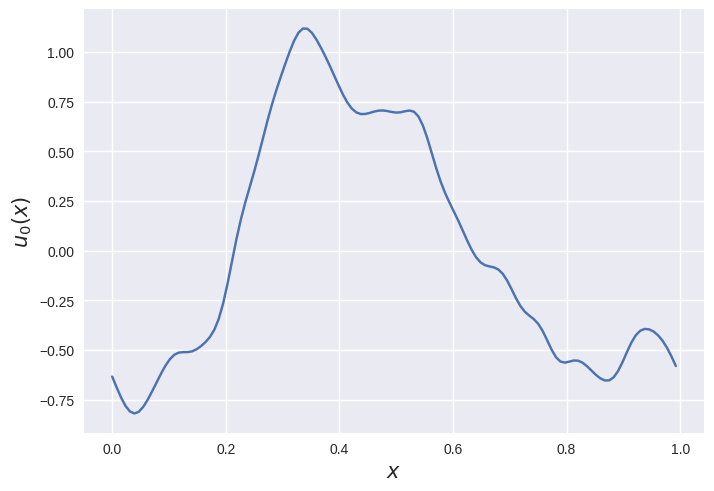

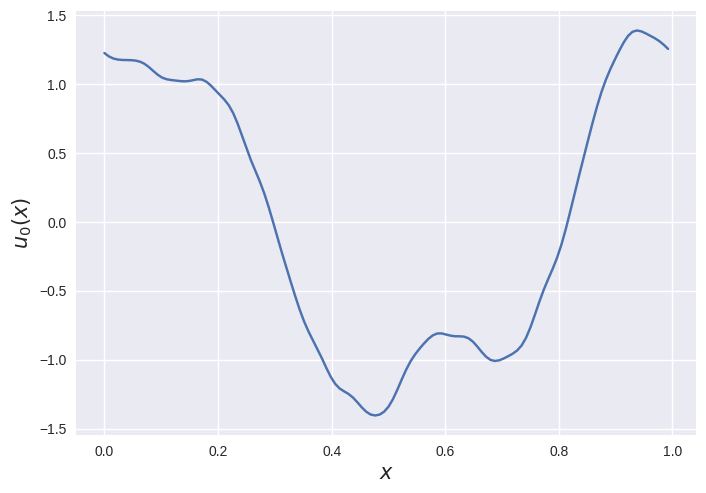

In [6]:
for i in range(5):
    x_train = x[i*169: i*169 + 1000]
    #print(x.shape, x[0,0])
    
    idx = 2

    plt.figure()
    plt.plot(grid, x_train[idx])
    plt.xlabel(r'$x$', size= 15)
    plt.ylabel(r'$u_0(x)$', size= 15)
    

## Fitting the GP: PCA

In [7]:
kernel = Matern(nu = 2.5)
#kernel = RBF()
gp = GaussianProcessRegressor(kernel, alpha = 1e-10) 

In [8]:
def train_test(x_train, x_test, y_train, y_test, n_pca):
    # Compute the PCA decoposition
    pca = PCA(n_components=n_pca)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    #print(x_train_pca.shape)
    #print(x_test_pca.shape)
    kernel = Matern(nu = 2.5)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = True, random_state= 1172023) 
    
    gp.fit(x_train_pca, y_train)
    pred= gp.predict(x_test_pca)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, gp

In [9]:
n_pca = 10
error = []
for i in range(5):
    x_train = x[i*169: i*169 + 1000]
    y_train = y[i*169: i*169 + 1000]
    #print(x_train.shape)
    pred, GP = train_test(x_train, x_test, y_train, y_test, n_pca)
    e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
    error.append(e)

print(np.mean(error))

0.024114421639892577


In [10]:
pca_modes = np.arange(5, 20)

pca_error = []
for n_pca in pca_modes:
    error = []
    for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        #print(x_train.shape)
        pred, GP = train_test(x_train, x_test, y_train, y_test, n_pca)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
    pca_error.append(np.mean(error))

#print(np.mean(error))

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


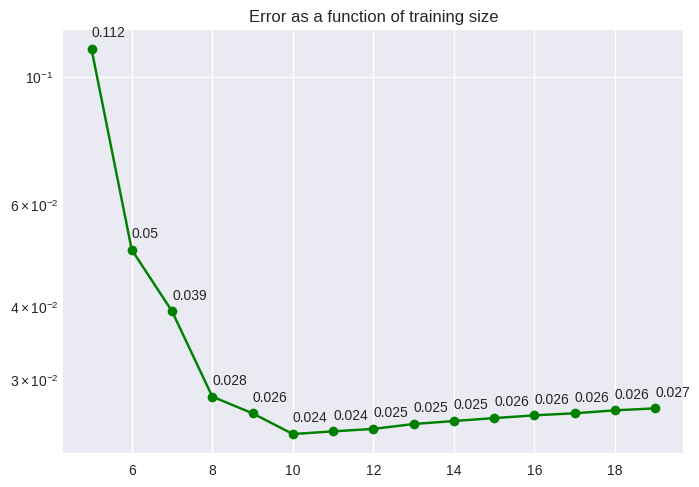

In [11]:
plt.figure()
plt.plot(pca_modes,pca_error, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")

for s, d in zip(pca_error, pca_modes):
    plt.annotate(np.round(s, 3), xy = (d ,s + s/20 ))
    
    
plt.show()

In [12]:
np.min(pca_error)

0.024114421639920697

In [7]:
def train_test(x_train, x_test, y_train, y_test, n_pca):
    # Compute the PCA decoposition
    pca = PCA(n_components=n_pca)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    #print(x_train_pca.shape)
    #print(x_test_pca.shape)
    kernel = Matern(nu = 2.5)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = True, random_state= 1172023) 
    
    gp.fit(x_train_pca, y_train)
    pred= gp.predict(x_test_pca)
    pred_train = gp.predict(x_train_pca)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, pred_train, gp

In [8]:
n_pca = 10

In [15]:
i = 1
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

pred, pred_train, GP = train_test(x_train, x_test, y_train, y_test, n_pca)

In [16]:
pred.shape, pred_train.shape

((200, 128), (1000, 128))

In [17]:
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e

0.024024327704213283

In [21]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    pred = []
    for i in tqdm(range(y_train.shape[-1])):
        model.fit(x_train, y_train[:, i])
        pred.append(model.predict(x_test))
        print(model.kernel_)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return np.stack(pred), model

In [23]:
pca = PCA(n_components=n_pca)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

x_train_pca.shape, x_test_pca.shape

((1000, 10), (200, 10))

In [25]:
kernel = Matern(nu = 2.5)
gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = True, random_state= 1172023) 
pred, model = train_test(x_train_pca, x_test_pca, y_train, y_test, n_pca, gp)


  1%|▎                                          | 1/128 [00:00<01:38,  1.29it/s]

Matern(length_scale=12.6, nu=2.5)


  2%|▋                                          | 2/128 [00:01<01:33,  1.35it/s]

Matern(length_scale=12.7, nu=2.5)


  2%|█                                          | 3/128 [00:02<01:30,  1.39it/s]

Matern(length_scale=12.6, nu=2.5)


  3%|█▎                                         | 4/128 [00:03<01:36,  1.29it/s]

Matern(length_scale=12.5, nu=2.5)


  4%|█▋                                         | 5/128 [00:03<01:34,  1.30it/s]

Matern(length_scale=12.5, nu=2.5)


  5%|██                                         | 6/128 [00:04<01:31,  1.33it/s]

Matern(length_scale=12.7, nu=2.5)


  5%|██▎                                        | 7/128 [00:05<01:30,  1.34it/s]

Matern(length_scale=12.9, nu=2.5)


  6%|██▋                                        | 8/128 [00:06<01:30,  1.33it/s]

Matern(length_scale=13, nu=2.5)


  7%|███                                        | 9/128 [00:07<01:40,  1.18it/s]

Matern(length_scale=13.1, nu=2.5)


  8%|███▎                                      | 10/128 [00:07<01:37,  1.22it/s]

Matern(length_scale=13.1, nu=2.5)


  9%|███▌                                      | 11/128 [00:08<01:34,  1.24it/s]

Matern(length_scale=13.1, nu=2.5)


  9%|███▉                                      | 12/128 [00:09<01:33,  1.25it/s]

Matern(length_scale=13.1, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 10%|████▎                                     | 13/128 [00:11<02:25,  1.27s/it]

Matern(length_scale=13.1, nu=2.5)


 11%|████▌                                     | 14/128 [00:12<02:03,  1.08s/it]

Matern(length_scale=13, nu=2.5)


 12%|████▉                                     | 15/128 [00:13<01:51,  1.01it/s]

Matern(length_scale=12.7, nu=2.5)


 12%|█████▎                                    | 16/128 [00:13<01:41,  1.10it/s]

Matern(length_scale=12.6, nu=2.5)


 13%|█████▌                                    | 17/128 [00:14<01:37,  1.14it/s]

Matern(length_scale=12.7, nu=2.5)


 14%|█████▉                                    | 18/128 [00:15<01:31,  1.20it/s]

Matern(length_scale=12.7, nu=2.5)


 15%|██████▏                                   | 19/128 [00:16<01:26,  1.25it/s]

Matern(length_scale=12.7, nu=2.5)


 16%|██████▌                                   | 20/128 [00:16<01:25,  1.27it/s]

Matern(length_scale=12.7, nu=2.5)


 16%|██████▉                                   | 21/128 [00:17<01:22,  1.30it/s]

Matern(length_scale=12.6, nu=2.5)


 17%|███████▏                                  | 22/128 [00:18<01:20,  1.31it/s]

Matern(length_scale=12.5, nu=2.5)


 18%|███████▌                                  | 23/128 [00:19<01:18,  1.33it/s]

Matern(length_scale=12.6, nu=2.5)


 19%|███████▉                                  | 24/128 [00:19<01:17,  1.34it/s]

Matern(length_scale=12.7, nu=2.5)


 20%|████████▏                                 | 25/128 [00:20<01:15,  1.37it/s]

Matern(length_scale=12.9, nu=2.5)


 20%|████████▌                                 | 26/128 [00:21<01:10,  1.44it/s]

Matern(length_scale=12.9, nu=2.5)


 21%|████████▊                                 | 27/128 [00:21<01:10,  1.42it/s]

Matern(length_scale=12.9, nu=2.5)


 22%|█████████▏                                | 28/128 [00:22<01:09,  1.44it/s]

Matern(length_scale=13, nu=2.5)


 23%|█████████▌                                | 29/128 [00:23<01:10,  1.40it/s]

Matern(length_scale=13.1, nu=2.5)


 23%|█████████▊                                | 30/128 [00:24<01:12,  1.35it/s]

Matern(length_scale=13.2, nu=2.5)


 24%|██████████▏                               | 31/128 [00:25<01:25,  1.14it/s]

Matern(length_scale=13.3, nu=2.5)


 25%|██████████▌                               | 32/128 [00:26<01:23,  1.15it/s]

Matern(length_scale=13.3, nu=2.5)


 26%|██████████▊                               | 33/128 [00:26<01:21,  1.17it/s]

Matern(length_scale=13.3, nu=2.5)


 27%|███████████▏                              | 34/128 [00:27<01:19,  1.18it/s]

Matern(length_scale=13.2, nu=2.5)


 27%|███████████▍                              | 35/128 [00:28<01:18,  1.18it/s]

Matern(length_scale=13.1, nu=2.5)


 28%|███████████▊                              | 36/128 [00:29<01:15,  1.23it/s]

Matern(length_scale=13, nu=2.5)


 29%|████████████▏                             | 37/128 [00:30<01:14,  1.22it/s]

Matern(length_scale=13.1, nu=2.5)


 30%|████████████▍                             | 38/128 [00:31<01:20,  1.12it/s]

Matern(length_scale=13.2, nu=2.5)


 30%|████████████▊                             | 39/128 [00:32<01:17,  1.14it/s]

Matern(length_scale=13.3, nu=2.5)


 31%|█████████████▏                            | 40/128 [00:32<01:15,  1.17it/s]

Matern(length_scale=13.1, nu=2.5)


 32%|█████████████▍                            | 41/128 [00:33<01:11,  1.22it/s]

Matern(length_scale=12.8, nu=2.5)


 33%|█████████████▊                            | 42/128 [00:34<01:09,  1.24it/s]

Matern(length_scale=12.5, nu=2.5)


 34%|██████████████                            | 43/128 [00:35<01:08,  1.24it/s]

Matern(length_scale=12.5, nu=2.5)


 34%|██████████████▍                           | 44/128 [00:36<01:06,  1.26it/s]

Matern(length_scale=12.7, nu=2.5)


 35%|██████████████▊                           | 45/128 [00:36<01:04,  1.28it/s]

Matern(length_scale=13, nu=2.5)


 36%|███████████████                           | 46/128 [00:37<01:05,  1.25it/s]

Matern(length_scale=12.8, nu=2.5)


 37%|███████████████▍                          | 47/128 [00:38<01:05,  1.23it/s]

Matern(length_scale=12.4, nu=2.5)


 38%|███████████████▊                          | 48/128 [00:39<01:09,  1.16it/s]

Matern(length_scale=12.2, nu=2.5)


 38%|████████████████                          | 49/128 [00:40<01:08,  1.16it/s]

Matern(length_scale=12.3, nu=2.5)


 39%|████████████████▍                         | 50/128 [00:41<01:04,  1.21it/s]

Matern(length_scale=12.6, nu=2.5)


 40%|████████████████▋                         | 51/128 [00:41<01:02,  1.24it/s]

Matern(length_scale=12.7, nu=2.5)


 41%|█████████████████                         | 52/128 [00:42<01:00,  1.26it/s]

Matern(length_scale=12.7, nu=2.5)


 41%|█████████████████▍                        | 53/128 [00:43<00:57,  1.30it/s]

Matern(length_scale=12.6, nu=2.5)


 42%|█████████████████▋                        | 54/128 [00:43<00:55,  1.33it/s]

Matern(length_scale=12.7, nu=2.5)


 43%|██████████████████                        | 55/128 [00:44<00:52,  1.39it/s]

Matern(length_scale=12.8, nu=2.5)


 44%|██████████████████▍                       | 56/128 [00:45<00:51,  1.41it/s]

Matern(length_scale=13, nu=2.5)


 45%|██████████████████▋                       | 57/128 [00:46<00:50,  1.40it/s]

Matern(length_scale=13, nu=2.5)


 45%|███████████████████                       | 58/128 [00:46<00:49,  1.40it/s]

Matern(length_scale=12.9, nu=2.5)


 46%|███████████████████▎                      | 59/128 [00:47<00:49,  1.40it/s]

Matern(length_scale=12.7, nu=2.5)


 47%|███████████████████▋                      | 60/128 [00:48<00:48,  1.41it/s]

Matern(length_scale=12.7, nu=2.5)


 48%|████████████████████                      | 61/128 [00:48<00:46,  1.45it/s]

Matern(length_scale=13, nu=2.5)


 48%|████████████████████▎                     | 62/128 [00:50<01:08,  1.03s/it]

Matern(length_scale=13.2, nu=2.5)


 49%|████████████████████▋                     | 63/128 [00:51<01:01,  1.06it/s]

Matern(length_scale=13.2, nu=2.5)


 50%|█████████████████████                     | 64/128 [00:52<00:54,  1.17it/s]

Matern(length_scale=12.9, nu=2.5)


 51%|█████████████████████▎                    | 65/128 [00:52<00:51,  1.23it/s]

Matern(length_scale=12.8, nu=2.5)


 52%|█████████████████████▋                    | 66/128 [00:53<00:48,  1.29it/s]

Matern(length_scale=12.7, nu=2.5)


 52%|█████████████████████▉                    | 67/128 [00:54<00:45,  1.33it/s]

Matern(length_scale=12.7, nu=2.5)


 53%|██████████████████████▎                   | 68/128 [00:54<00:44,  1.36it/s]

Matern(length_scale=12.8, nu=2.5)


 54%|██████████████████████▋                   | 69/128 [00:55<00:41,  1.42it/s]

Matern(length_scale=13, nu=2.5)


 55%|██████████████████████▉                   | 70/128 [00:56<00:40,  1.43it/s]

Matern(length_scale=13.1, nu=2.5)


 55%|███████████████████████▎                  | 71/128 [00:56<00:38,  1.47it/s]

Matern(length_scale=12.9, nu=2.5)


 56%|███████████████████████▋                  | 72/128 [00:57<00:38,  1.46it/s]

Matern(length_scale=12.6, nu=2.5)


 57%|███████████████████████▉                  | 73/128 [00:58<00:38,  1.42it/s]

Matern(length_scale=12.4, nu=2.5)


 58%|████████████████████████▎                 | 74/128 [00:58<00:38,  1.40it/s]

Matern(length_scale=12.4, nu=2.5)


 59%|████████████████████████▌                 | 75/128 [01:00<00:47,  1.11it/s]

Matern(length_scale=12.6, nu=2.5)


 59%|████████████████████████▉                 | 76/128 [01:00<00:43,  1.19it/s]

Matern(length_scale=12.7, nu=2.5)


 60%|█████████████████████████▎                | 77/128 [01:01<00:41,  1.23it/s]

Matern(length_scale=12.6, nu=2.5)


 61%|█████████████████████████▌                | 78/128 [01:02<00:39,  1.26it/s]

Matern(length_scale=12.5, nu=2.5)


 62%|█████████████████████████▉                | 79/128 [01:03<00:38,  1.28it/s]

Matern(length_scale=12.4, nu=2.5)


 62%|██████████████████████████▎               | 80/128 [01:03<00:37,  1.29it/s]

Matern(length_scale=12.5, nu=2.5)


 63%|██████████████████████████▌               | 81/128 [01:04<00:35,  1.34it/s]

Matern(length_scale=12.6, nu=2.5)


 64%|██████████████████████████▉               | 82/128 [01:05<00:32,  1.43it/s]

Matern(length_scale=12.8, nu=2.5)


 65%|███████████████████████████▏              | 83/128 [01:05<00:31,  1.43it/s]

Matern(length_scale=13, nu=2.5)


 66%|███████████████████████████▌              | 84/128 [01:06<00:29,  1.47it/s]

Matern(length_scale=13, nu=2.5)


 66%|███████████████████████████▉              | 85/128 [01:07<00:28,  1.50it/s]

Matern(length_scale=12.8, nu=2.5)


 67%|████████████████████████████▏             | 86/128 [01:07<00:27,  1.52it/s]

Matern(length_scale=12.8, nu=2.5)


 68%|████████████████████████████▌             | 87/128 [01:08<00:27,  1.50it/s]

Matern(length_scale=13, nu=2.5)


 69%|████████████████████████████▉             | 88/128 [01:09<00:27,  1.43it/s]

Matern(length_scale=13.2, nu=2.5)


 70%|█████████████████████████████▏            | 89/128 [01:10<00:28,  1.37it/s]

Matern(length_scale=13.2, nu=2.5)


 70%|█████████████████████████████▌            | 90/128 [01:10<00:28,  1.35it/s]

Matern(length_scale=13.1, nu=2.5)


 71%|█████████████████████████████▊            | 91/128 [01:11<00:28,  1.31it/s]

Matern(length_scale=13, nu=2.5)


 72%|██████████████████████████████▏           | 92/128 [01:12<00:27,  1.33it/s]

Matern(length_scale=13, nu=2.5)


 73%|██████████████████████████████▌           | 93/128 [01:13<00:26,  1.32it/s]

Matern(length_scale=13.1, nu=2.5)


 73%|██████████████████████████████▊           | 94/128 [01:13<00:25,  1.32it/s]

Matern(length_scale=13.2, nu=2.5)


 74%|███████████████████████████████▏          | 95/128 [01:14<00:25,  1.30it/s]

Matern(length_scale=13.3, nu=2.5)


 75%|███████████████████████████████▌          | 96/128 [01:15<00:25,  1.27it/s]

Matern(length_scale=13.2, nu=2.5)


 76%|███████████████████████████████▊          | 97/128 [01:16<00:24,  1.29it/s]

Matern(length_scale=13.1, nu=2.5)


 77%|████████████████████████████████▏         | 98/128 [01:17<00:22,  1.32it/s]

Matern(length_scale=13, nu=2.5)


 77%|████████████████████████████████▍         | 99/128 [01:18<00:24,  1.19it/s]

Matern(length_scale=13.1, nu=2.5)


 78%|████████████████████████████████         | 100/128 [01:19<00:24,  1.16it/s]

Matern(length_scale=13.3, nu=2.5)


 79%|████████████████████████████████▎        | 101/128 [01:19<00:23,  1.14it/s]

Matern(length_scale=13.5, nu=2.5)


 80%|████████████████████████████████▋        | 102/128 [01:20<00:23,  1.12it/s]

Matern(length_scale=13.4, nu=2.5)


 80%|████████████████████████████████▉        | 103/128 [01:21<00:22,  1.10it/s]

Matern(length_scale=13.2, nu=2.5)


 81%|█████████████████████████████████▎       | 104/128 [01:22<00:19,  1.21it/s]

Matern(length_scale=13, nu=2.5)


 82%|█████████████████████████████████▋       | 105/128 [01:23<00:17,  1.31it/s]

Matern(length_scale=12.9, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 83%|█████████████████████████████████▉       | 106/128 [01:25<00:27,  1.26s/it]

Matern(length_scale=13.1, nu=2.5)


 84%|██████████████████████████████████▎      | 107/128 [01:26<00:23,  1.14s/it]

Matern(length_scale=13.3, nu=2.5)


 84%|██████████████████████████████████▌      | 108/128 [01:27<00:21,  1.06s/it]

Matern(length_scale=13.5, nu=2.5)


 85%|██████████████████████████████████▉      | 109/128 [01:28<00:18,  1.00it/s]

Matern(length_scale=13.3, nu=2.5)


 86%|███████████████████████████████████▏     | 110/128 [01:28<00:16,  1.07it/s]

Matern(length_scale=13, nu=2.5)


 87%|███████████████████████████████████▌     | 111/128 [01:29<00:14,  1.18it/s]

Matern(length_scale=12.8, nu=2.5)


 88%|███████████████████████████████████▉     | 112/128 [01:30<00:12,  1.26it/s]

Matern(length_scale=12.8, nu=2.5)


 88%|████████████████████████████████████▏    | 113/128 [01:30<00:12,  1.24it/s]

Matern(length_scale=13.1, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 89%|████████████████████████████████████▌    | 114/128 [01:33<00:18,  1.30s/it]

Matern(length_scale=13.3, nu=2.5)


 90%|████████████████████████████████████▊    | 115/128 [01:34<00:14,  1.15s/it]

Matern(length_scale=13.1, nu=2.5)


 91%|█████████████████████████████████████▏   | 116/128 [01:35<00:12,  1.08s/it]

Matern(length_scale=12.9, nu=2.5)


 91%|█████████████████████████████████████▍   | 117/128 [01:35<00:10,  1.05it/s]

Matern(length_scale=12.9, nu=2.5)


 92%|█████████████████████████████████████▊   | 118/128 [01:36<00:08,  1.12it/s]

Matern(length_scale=13.1, nu=2.5)


 93%|██████████████████████████████████████   | 119/128 [01:37<00:07,  1.13it/s]

Matern(length_scale=13.3, nu=2.5)


 94%|██████████████████████████████████████▍  | 120/128 [01:38<00:06,  1.17it/s]

Matern(length_scale=13.3, nu=2.5)


 95%|██████████████████████████████████████▊  | 121/128 [01:38<00:05,  1.21it/s]

Matern(length_scale=13.1, nu=2.5)


 95%|███████████████████████████████████████  | 122/128 [01:39<00:04,  1.29it/s]

Matern(length_scale=13, nu=2.5)


 96%|███████████████████████████████████████▍ | 123/128 [01:40<00:03,  1.39it/s]

Matern(length_scale=12.9, nu=2.5)


 97%|███████████████████████████████████████▋ | 124/128 [01:40<00:02,  1.44it/s]

Matern(length_scale=12.9, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 98%|████████████████████████████████████████ | 125/128 [01:42<00:03,  1.12s/it]

Matern(length_scale=12.8, nu=2.5)


 98%|████████████████████████████████████████▎| 126/128 [01:43<00:02,  1.02s/it]

Matern(length_scale=12.5, nu=2.5)


 99%|████████████████████████████████████████▋| 127/128 [01:44<00:00,  1.06it/s]

Matern(length_scale=12.4, nu=2.5)


100%|█████████████████████████████████████████| 128/128 [01:45<00:00,  1.22it/s]

Matern(length_scale=12.4, nu=2.5)


In [28]:
pred = pred.T
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e

0.02402416043437646

In [27]:
pred.shape

(128, 200)

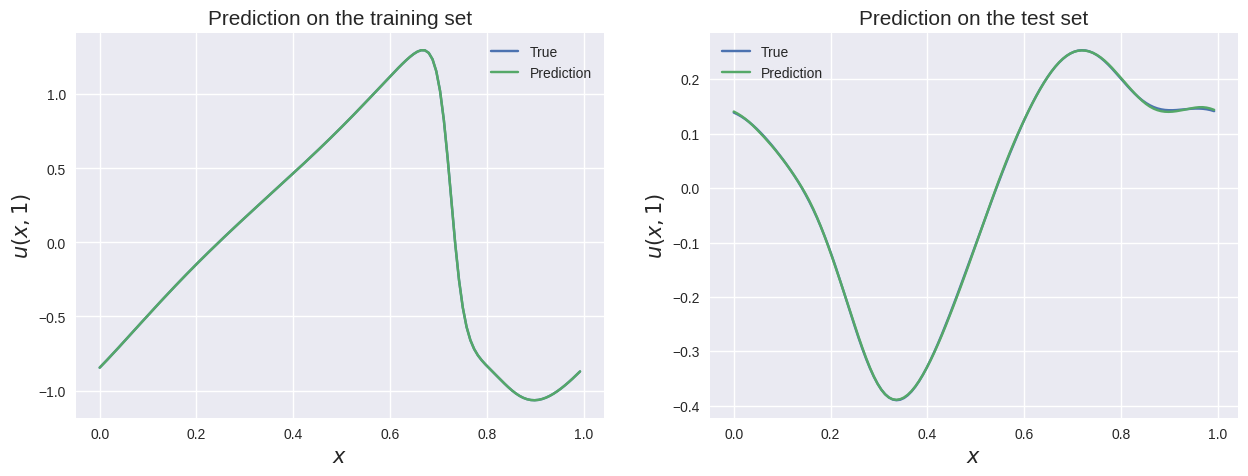

In [15]:
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y_train[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

In [37]:
np.random.default_rng()

Generator(PCG64) at 0x7F2837E02580

# Linear regression

In [40]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    # Compute the PCA decoposition
    pca = PCA(n_components=n_pca)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    
    model.fit(x_train_pca, y_train)
    pred= model.predict(x_test_pca)
    pred_train = model.predict(x_train_pca)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model, pred_train

In [41]:
model = LinearRegression()

In [42]:
pca_modes = np.arange(1, 20)

pca_error = []
for n_pca in pca_modes:
    error = []
    for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train, x_test, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
    pca_error.append(np.mean(error))

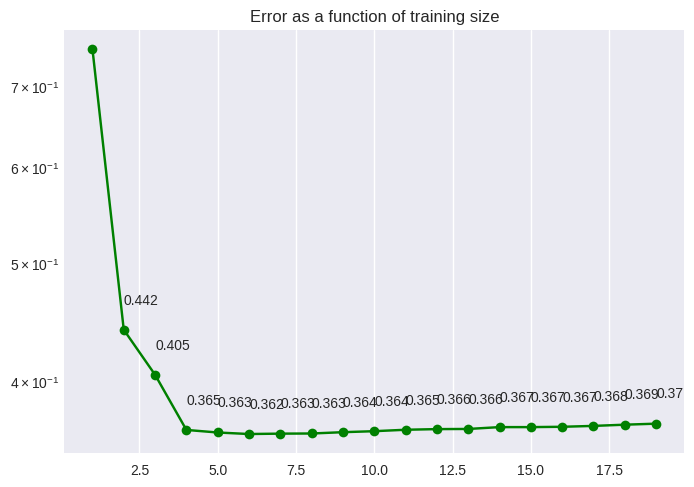

In [43]:
plt.figure()
plt.plot(pca_modes,pca_error, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")

for s, d in zip(pca_error, pca_modes):
    plt.annotate(np.round(s, 3), xy = (d ,s + s/20 ))
    
    
plt.show()

In [44]:
np.min(pca_error), np.argmin(pca_error)

(0.3623501111918679, 5)

In [45]:
i = 0
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

n_pca = 5
pred, model, pred_train = train_test(x_train, x_test, y_train, y_test, n_pca, model)
#pred_train = model.predict(x_train)

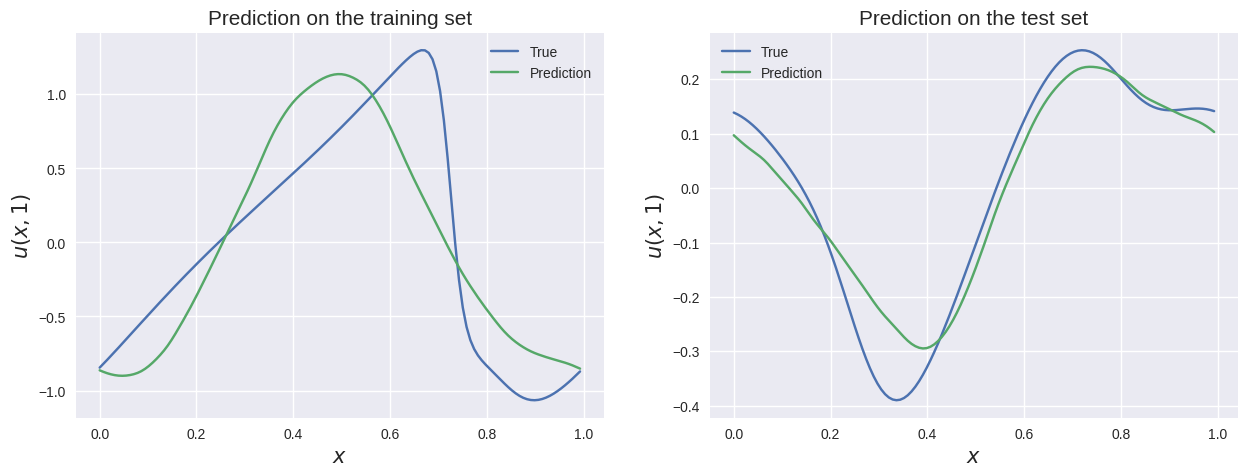

In [46]:
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y_train[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

# Polynomial regression

In [47]:
poly = PolynomialFeatures(2)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

model = LinearRegression()

In [51]:
pca_modes = np.arange(1, 20)

pca_error = []
for n_pca in pca_modes:
    error = []
    for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
    pca_error.append(np.mean(error))

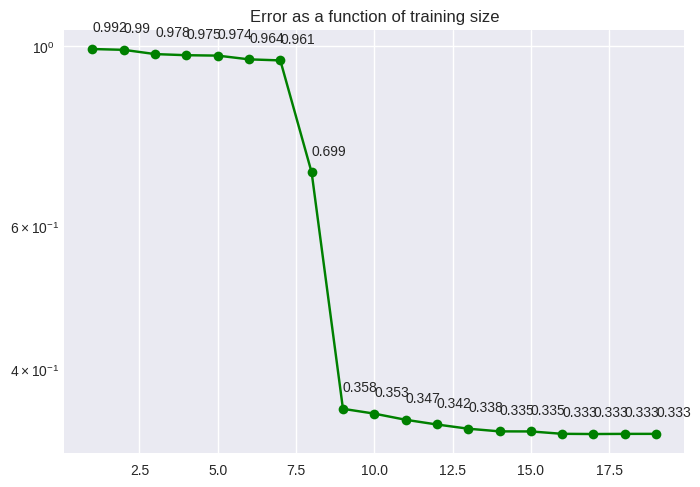

In [52]:
plt.figure()
plt.plot(pca_modes,pca_error, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")

for s, d in zip(pca_error, pca_modes):
    plt.annotate(np.round(s, 3), xy = (d ,s + s/20 ))
    
    
plt.show()

In [53]:
np.min(pca_error), np.argmin(pca_error)

(0.332854107418273, 16)

In [54]:
i = 0
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

n_pca = 17
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

pred, model, pred_train = train_test(x_train, x_test, y_train, y_test, n_pca, model)
#pred_train = model.predict(x_train)

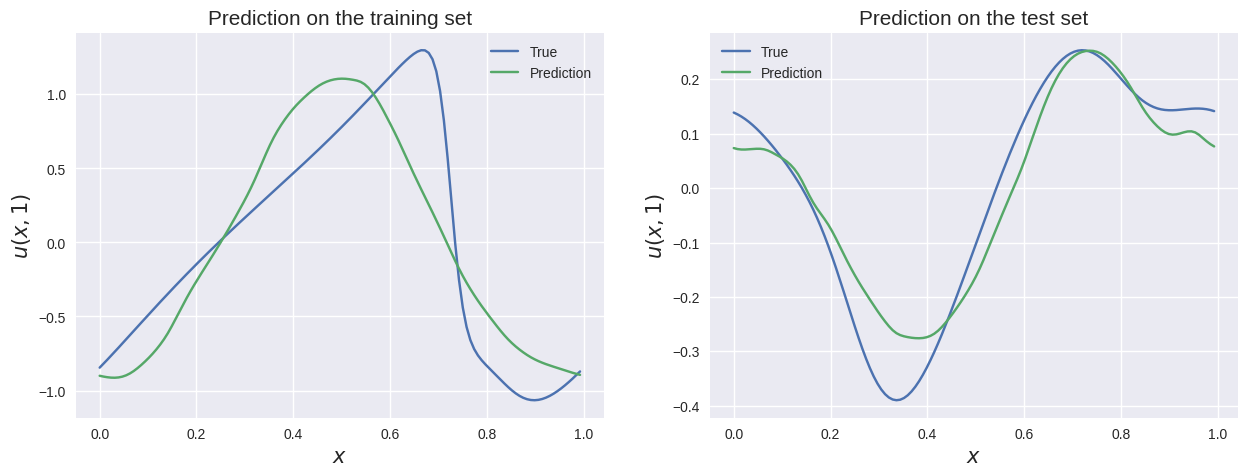

In [55]:
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y_train[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

# Polynomial regression deg 3

In [56]:
poly = PolynomialFeatures(3)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

model = LinearRegression()

In [58]:
pca_modes = np.arange(5, 20)

pca_error = []
for n_pca in pca_modes:
    print(n_pca)
    error = []
    for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
    pca_error.append(np.mean(error))

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


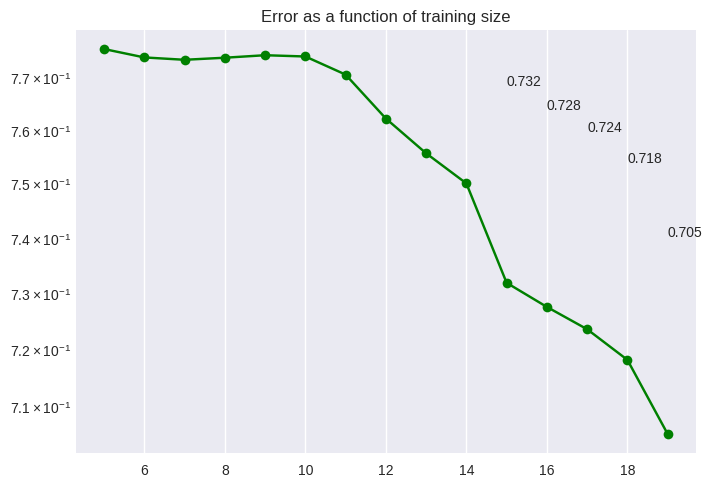

In [59]:
plt.figure()
plt.plot(pca_modes,pca_error, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")

for s, d in zip(pca_error, pca_modes):
    plt.annotate(np.round(s, 3), xy = (d ,s + s/20 ))
    
    
plt.show()

In [ ]:
np.min(pca_error), np.argmin(pca_error)

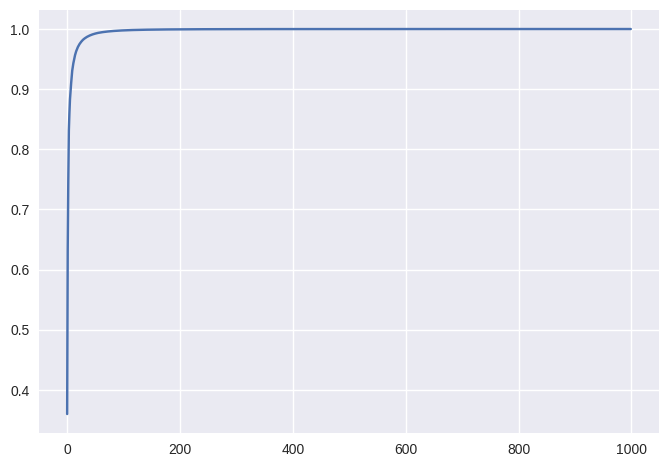

13

In [65]:


i = 0
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)


pca = PCA(n_components=1000)
x_train_pca = pca.fit_transform(x_train_poly)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [68]:
n_pca = 13
print(n_pca)
error = []
for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
print(np.mean(error))

13
0.7556950345566795


In [66]:
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]

42

In [67]:
n_pca = 42
print(n_pca)
error = []
for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
print(np.mean(error))

42
0.5990256818282329


In [69]:
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.999)[0][0]

149

In [70]:
n_pca = 149
print(n_pca)
error = []
for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
print(np.mean(error))

149
0.24391256920185636


In [71]:
def train_test_no_pca(x_train, x_test, y_train, y_test, model):

    
    model.fit(x_train, y_train)
    pred= model.predict(x_test)
    pred_train = model.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model, pred_train

In [72]:
error = []
for i in range(5):
        x_train = x[i*169: i*169 + 1000]
        y_train = y[i*169: i*169 + 1000]
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        #print(x_train.shape)
        pred, GP, pred_train = train_test_no_pca(x_train_poly, x_test_poly, y_train, y_test, model)
        e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
        error.append(e)
print(np.mean(error))

0.2814261882757557


In [74]:
i = 0
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

n_pca = 149
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

pred, model, pred_train = train_test(x_train_poly, x_test_poly, y_train, y_test, n_pca, model)
#pred_train = model.predict(x_train)

In [75]:
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

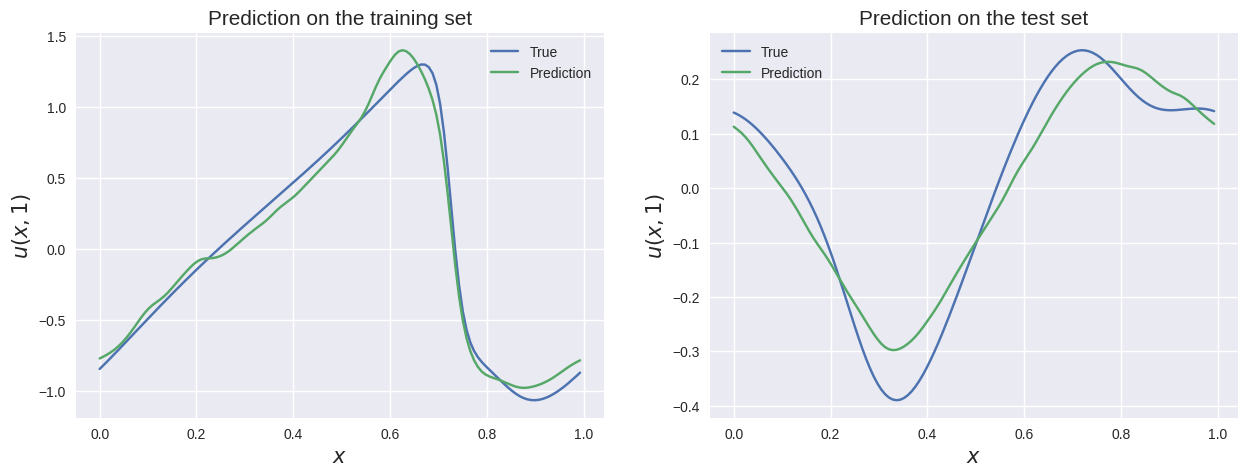

In [76]:
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y_train[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()